In [25]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
#from pyspark.mlib.stat import Statistis
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row
from pyspark.ml.stat import Correlation
from pyspark.ml.stat import Summarizer
from pyspark.ml.feature import VectorAssembler

In [2]:
spark = SparkSession\
.builder\
.appName("Python Spark SQL")\
.config("spark.some.config.option", "some-value")\
.getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/09 10:36:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/09 10:36:22 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/11/09 10:36:22 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Python Spark SQL>

In [5]:
# Dta Source: UCI Machine Learning
# read_csv has many options -- can specify cols to load
carsdf = pd.read_csv("cars_uci.csv", header=[0], skiprows=[1]) #pd.read_csv(data, usecols=['MPG', 'Hors])
carsdf

,Car,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model,Origin
0,Chevrolet Chevelle Malibu,18.0,8,307.0,130.0,3504.0,12.0,70,US
1,Buick Skylark 320,15.0,8,350.0,165.0,3693.0,11.5,70,US
2,Plymouth Satellite,18.0,8,318.0,150.0,3436.0,11.0,70,US
3,AMC Rebel SST,16.0,8,304.0,150.0,3433.0,12.0,70,US
4,Ford Torino,17.0,8,302.0,140.0,3449.0,10.5,70,US
...,...,...,...,...,...,...,...,...,...
401,Ford Mustang GL,27.0,4,140.0,86.0,2790.0,15.6,82,US
402,Volkswagen Pickup,44.0,4,97.0,52.0,2130.0,24.6,82,Europe
403,Dodge Rampage,32.0,4,135.0,84.0,2295.0,11.6,82,US
404,Ford Ranger,28.0,4,120.0,79.0,2625.0,18.6,82,US


In [6]:
# just get US origin Cars
usadf = carsdf.loc[(carsdf.Origin == 'US')]

In [7]:
usadf.columns

Index(['Car', 'MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model', 'Origin'],
      dtype='object')

In [8]:
cols = ['Car', 'Model', 'Origin']
usadf2 = usadf[['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration']].copy()
usadf2

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration
0,18.0,8,307.0,130.0,3504.0,12.0
1,15.0,8,350.0,165.0,3693.0,11.5
2,18.0,8,318.0,150.0,3436.0,11.0
3,16.0,8,304.0,150.0,3433.0,12.0
4,17.0,8,302.0,140.0,3449.0,10.5
...,...,...,...,...,...,...
400,27.0,4,151.0,90.0,2950.0,17.3
401,27.0,4,140.0,86.0,2790.0,15.6
403,32.0,4,135.0,84.0,2295.0,11.6
404,28.0,4,120.0,79.0,2625.0,18.6


<function matplotlib.pyplot.show(close=None, block=None)>

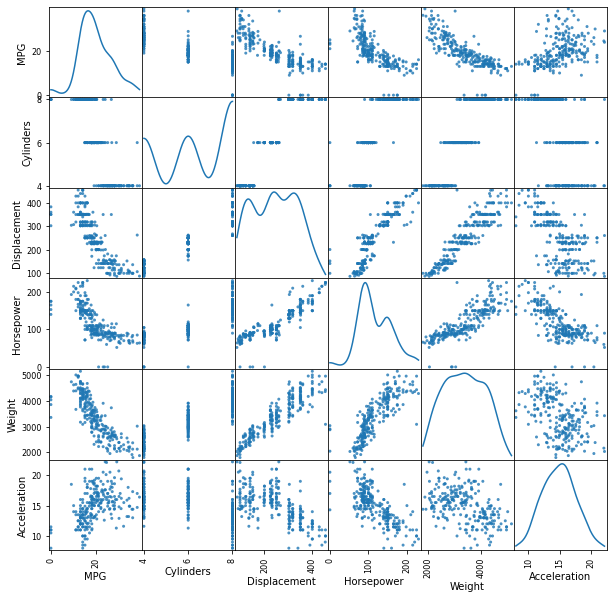

In [9]:
scatter_matrix(usadf2, alpha=0.8, figsize=(10, 10), diagonal='kde')

# show the plot
plt.show

In [10]:
#Create PySpark DataFrame from Pandas
sparkDF = spark.createDataFrame(usadf2)
sparkDF.printSchema()
sparkDF.show(10)

root
 |-- MPG: double (nullable = true)
 |-- Cylinders: long (nullable = true)
 |-- Displacement: double (nullable = true)
 |-- Horsepower: double (nullable = true)
 |-- Weight: double (nullable = true)
 |-- Acceleration: double (nullable = true)



+----+---------+------------+----------+------+------------+
| MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|
+----+---------+------------+----------+------+------------+
|18.0|        8|       307.0|     130.0|3504.0|        12.0|
|15.0|        8|       350.0|     165.0|3693.0|        11.5|
|18.0|        8|       318.0|     150.0|3436.0|        11.0|
|16.0|        8|       304.0|     150.0|3433.0|        12.0|
|17.0|        8|       302.0|     140.0|3449.0|        10.5|
|15.0|        8|       429.0|     198.0|4341.0|        10.0|
|14.0|        8|       454.0|     220.0|4354.0|         9.0|
|14.0|        8|       440.0|     215.0|4312.0|         8.5|
|14.0|        8|       455.0|     225.0|4425.0|        10.0|
|15.0|        8|       390.0|     190.0|3850.0|         8.5|
+----+---------+------------+----------+------+------------+
only showing top 10 rows



In [14]:
# convert to vector column first
#https://stackoverflow.com/questions/52214404/how-to-get-the-correlation-matrix-of-a-pyspark-data-frame

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=sparkDF.columns,\
                           outputCol=vector_col)
df_vector = assembler.transform(sparkDF).select(vector_col)
matrix = Correlation.corr(df_vector, vector_col)
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()
cor_np

array([[ 1.        , -0.80422401, -0.81331822, -0.71260256, -0.8080557 ,
         0.42988478],
       [-0.80422401,  1.        ,  0.93527116,  0.81611135,  0.87949113,
        -0.57874646],
       [-0.81331822,  0.93527116,  1.        ,  0.88422304,  0.91756753,
        -0.62957575],
       [-0.71260256,  0.81611135,  0.88422304,  1.        ,  0.81644437,
        -0.71054511],
       [-0.8080557 ,  0.87949113,  0.91756753,  0.81644437,  1.        ,
        -0.44905819],
       [ 0.42988478, -0.57874646, -0.62957575, -0.71054511, -0.44905819,
         1.        ]])

In [15]:
df_vector.show(5)

+--------------------+
|       corr_features|
+--------------------+
|[18.0,8.0,307.0,1...|
|[15.0,8.0,350.0,1...|
|[18.0,8.0,318.0,1...|
|[16.0,8.0,304.0,1...|
|[17.0,8.0,302.0,1...|
+--------------------+
only showing top 5 rows



In [19]:
# get the perason default correlation
matrix  = Correlation.corr(df_vector, vector_col)
scor_np = matrix.collect()[0][matrix.columns[0]].toArray()

In [20]:
# get spearman correlation matrix
smatrix = Correlation.corr(df_vector, vector_col, method='spearman')
scor_np = matrix.collect()[0][matrix.columns[0]].toArray()

In [21]:
print('\t'.join([col[0:5] for col in sparkDF.columns]))
print("\n".join("\t".join(["{0:.2f}".format(num) for num in list(subList)]) for subList in list(scor_np)))

MPG	Cylin	Displ	Horse	Weigh	Accel
1.00	-0.80	-0.81	-0.71	-0.81	0.43
-0.80	1.00	0.94	0.82	0.88	-0.58
-0.81	0.94	1.00	0.88	0.92	-0.63
-0.71	0.82	0.88	1.00	0.82	-0.71
-0.81	0.88	0.92	0.82	1.00	-0.45
0.43	-0.58	-0.63	-0.71	-0.45	1.00


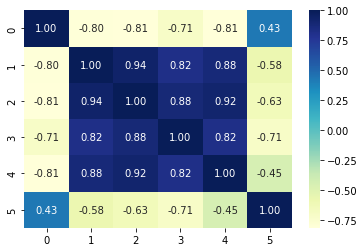

In [26]:
#Colourmap needs work -- als axes should be labelled
ax = sns.heatmap(cor_np, annot=True, fmt=".2f", cmap="YlGnBu")

In [27]:
plt.show()